In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re

import matplotlib.pyplot as plt
import numpy as np


In [3]:
base = "/Users/lucreziavaleriani/Desktop/orfeo_scratch/utils_locate/simulations_rRACES/test_dr/out/clonal/sim_21/cov_70_p_0.9"
data = pd.read_csv(base + "/mirr_smooth_snv.csv", sep = ',', on_bad_lines='skip') 

In [4]:
data['pos'] = range(1, len(data) + 1)
data['baf'] = data['median_baf'].apply(lambda x: 1 - x if x > 0.5 else x)
data = data[data['baf']>0]
data_input = {'baf':torch.tensor(np.array(data.baf).reshape(-1, 1)),
            'dr':torch.tensor(np.array(data.median_dr).reshape(-1, 1)),
            'dp_snp':torch.tensor(np.array(data.mean_dp).reshape(-1, 1)),
            'orginal_baf':torch.tensor(np.array(data.median_baf).reshape(-1, 1)),
            'vaf':torch.tensor(np.array(data.vaf).reshape(-1, 1)),
            'dp_snv':torch.tensor(np.array(data.DP).reshape(-1, 1))}

In [24]:
from locate.utils import estimate_ploidy
ploidy, seg_table = estimate_ploidy(data, return_details=True)
print(f"Ploidy ≈ {ploidy:.3f}")

Ploidy ≈ 2.425


In [25]:
# T = data.baf.shape[0]
# prior_bp = torch.zeros(T)
# prior_bp[[1115, 4464, 4673]] = 1.0       

In [26]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [30]:
fix_ploidy = False
print(ploidy)

2.424880202902391


In [44]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf":data_input["baf"],
                         "dr":data_input["dr"], 
                         "dp_snp":data_input["dp_snp"], 
                         "vaf": data_input["vaf"], 
                         "dp": data_input["dp_snv"]})

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "fix_ploidy" : fix_ploidy, 
                         "prior_purity": 0.9,
                         "prior_ploidy": float(ploidy),
                         "scaling_factors": [1,1,1],
                         'hidden_dim': 4,
                         "prior_bp": None,
                        "lambda_cn": 1.0,          # ΔCN penalty slope used to shape the prior
                        "alpha_conc": 50.0,        # global Dirichlet concentration (higher = stronger prior)
                        "alpha_self_boost": 3.0,   # extra mass on the diagonal
                        "alpha_dip_boost": 0.5,    # extra mass on diploid column (if present)
                        "bp_strength": 3.0,
                        "sample_type":"clinical"})


/var/folders/rp/hjbttfr92hb_xymj39jz8jl00000gn/T/ipykernel_94860/4061752610.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "prior_ploidy": float(ploidy),


In [45]:
ll = locate.run(steps = 100, param_optimizer = {"lr" : 0.05}, guide_kind="normal")

ELBO: -4932.523425253  : 100%|██████████| 100/100 [00:02<00:00, 47.98it/s]


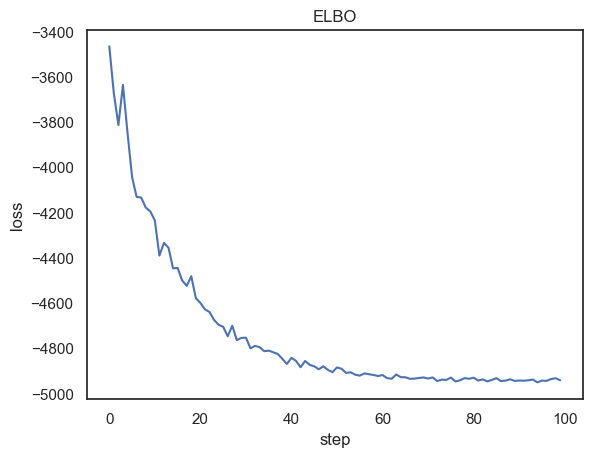

In [46]:
plot_loss(ll[0])

In [47]:
params = locate.learned_parameters_Clonal()

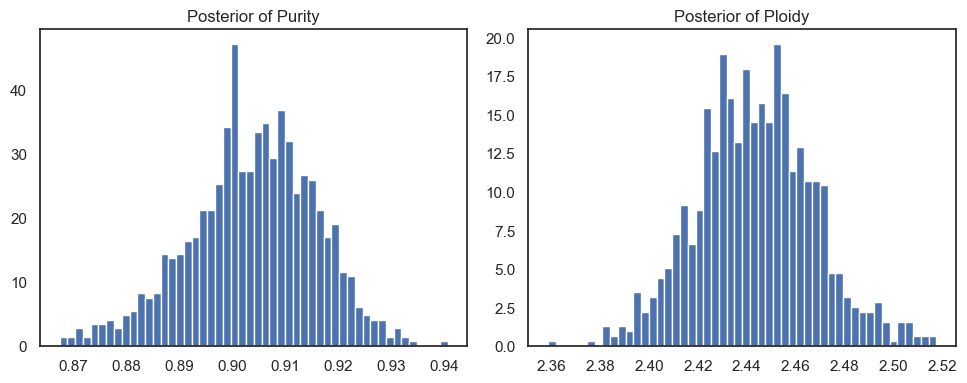

In [35]:
from locate.utils import plot_purity_ploidy_hist
draws = locate.posterior_draws(num_samples=1000, sites=["purity","ploidy"])
plot_purity_ploidy_hist(draws)


In [48]:
purity = params['purity']
if not fix_ploidy:
    ploidy = params['ploidy']
else:
    ploidy = None
print(purity, ploidy)

[0.9074635] [2.4364836]


In [49]:
res_plot = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

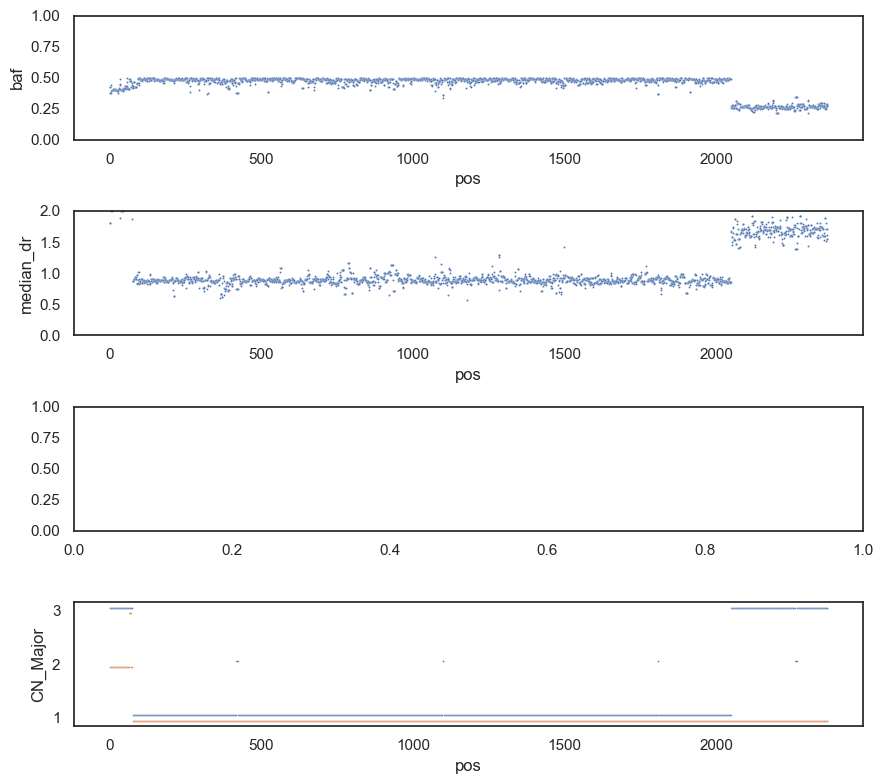

In [50]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(9, 8))

baf = sns.scatterplot(data=data, x="pos", y="baf", s=2, ax=axes[0])
dr = sns.scatterplot(data=data, x="pos", y="median_dr", s=2, ax=axes[1])

cn = sns.scatterplot(data=res_plot, x="pos", y="CN_Major", s=1, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res_plot, x="pos", y="CN_minor", s=1, ax=axes[3], legend=False)

axes[0].set_ylim(0,1) 
axes[1].set_ylim(0,2) 
axes[2].set_ylim(0,1) 

fig.tight_layout()

In [51]:
res = pd.DataFrame({'CN_Major':params["CN_Major"],
                    'CN_minor':params["CN_minor"],
                    'pos':[i for i in range(len(params["CN_minor"]))]})

In [52]:
from locate.evaluation.metric import score_cn_predictions
out_df = score_cn_predictions(data, res, sample_name="sim_1")

In [53]:
out_df['summary']

,sample,n_positions,allelic_accuracy,total_cn_accuracy,total_cn_mae,precision_totalCN_macro,recall_totalCN_macro,f1_totalCN_macro,precision_pair_macro,recall_pair_macro,f1_pair_macro
0,sim_1,2366,0.989856,0.989856,0.011412,0.998768,0.962029,0.979642,0.998768,0.962029,0.979642
